# Baseline **LSTM** Frame Predictor

A companion to the Transformer notebook — shares the same dataset loading,
section layout, and training loop so you can compare apples‑to‑apples.

<small>*(Sections are numbered & boxed exactly like the Transformer notebook.)*</small>

In [1]:
# ╔════════════════════════════╗
# ║ 0. Environment – GPU check ║
# ╚════════════════════════════╝
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ {len(gpus)} GPU(s) available: {[gpu.name for gpu in gpus]}")
    # Set mixed precision policy
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("⚠️ No GPU found. Training will be slow.")


2025-05-01 15:21:42.804228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 15:21:42.812872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746109302.823055   56969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746109302.825921   56969 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746109302.833840   56969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ 1 GPU(s) available: ['/physical_device:GPU:0']


In [2]:
# ╔═════════════════════════════════╗
# ║ 1. Load train/val/test datasets ║
# ╚═════════════════════════════════╝
DATA_PATH = "../processed_data/transformer_dataset/"

full_ds = tf.data.Dataset.load(DATA_PATH)

def filter_split(split_id):
    return full_ds.filter(lambda meta, x, y: meta[2] == split_id)

train_ds = filter_split(0).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds   = filter_split(1).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds  = filter_split(2).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)

print("✅ Datasets loaded and batched.")


I0000 00:00:1746109304.781238   56969 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Datasets loaded and batched.


In [3]:
# ╔══════════════════════╗
# ║ 2. Build LSTM Model ║
# ╚══════════════════════╝
from tensorflow.keras import layers, models

MAX_SEQ_LEN   = 100
NUM_ENTITIES  = 23
INPUT_DIM     = NUM_ENTITIES * 2   # x and y only → 46

inputs = tf.keras.Input(shape=(MAX_SEQ_LEN, INPUT_DIM))  # (batch, 100, 46)

x = layers.Masking(mask_value=0.0)(inputs)

# x = layers.LSTM(256, return_sequences=True)(x)
# To avoid GPU error:
from tensorflow.keras.layers import RNN, LSTMCell
x = RNN(LSTMCell(256), return_sequences=True)(x)

x = layers.Dropout(0.3)(x)
# x = layers.LSTM(128, return_sequences=False)(x)
# To avoid GPU error:
x = RNN(LSTMCell(256), return_sequences=False)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(INPUT_DIM)(x)  # predict next frame (46 values)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 100, 46)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100, 46)   │          0 │ cast[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 100, 46)   │          0 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 100)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn (RNN)           │ (None, 100, 256)  │    310,272 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 256)  │          0 │ rnn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_1 (RNN)         │ (None, 256)       │    525,312 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ rnn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 46)        │     11,822 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 847,406 (3.23 MB)

 Trainable params: 847,406 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# ╔══════════════════════╗
# ║ 3. Compile Model    ║
# ╚══════════════════════╝
import tensorflow.keras.backend as K

def euclidean_distance_loss(y_true, y_pred):
    # per-sample euclidean distance, then mean over batch
    sq_diff = K.square(y_pred - y_true)         # (batch,46)
    sum_sq  = K.sum(sq_diff, axis=-1)           # (batch,)
    dist    = K.sqrt(sum_sq + 1e-6)             # add epsilon for numerical stability
    return K.mean(dist)                         # scalar

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=euclidean_distance_loss,
    metrics=["mae"]
)


In [5]:
# ╔════════════════════════════════════════╗
# ║ 4. Set up callbacks (EarlyStopping etc) ║
# ╚════════════════════════════════════════╝
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath="saved_models/lstm_position_only_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [6]:
# ╔═══════════════════════════════════════════╗
# ║ 5. Train the model (with timing & callbacks) ║
# ╚═══════════════════════════════════════════╝
EPOCHS = 100
STEPS_PER_EPOCH_TRAIN = 1000
STEPS_PER_EPOCH_VAL = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_steps=STEPS_PER_EPOCH_VAL,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)


Epoch 1/100


I0000 00:00:1746109307.253562   57082 service.cc:152] XLA service 0x7f54d80d8740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746109307.253593   57082 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-01 15:21:47.308347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746109307.641882   57082 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-01 15:21:48.876156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63_0', 68 bytes spill stores, 108 bytes spill loads

2025-05-01 15:21:49.103736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_70',

   3/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - loss: 2.4737 - mae: 0.3128  

I0000 00:00:1746109311.750169   57082 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.9538 - mae: 0.1115
Epoch 1: val_loss improved from inf to 0.55130, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 224s 218ms/step - loss: 0.9536 - mae: 0.1115 - val_loss: 0.5513 - val_mae: 0.0654
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.5624 - mae: 0.0660
Epoch 2: val_loss improved from 0.55130 to 0.42538, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 214s 214ms/step - loss: 0.5623 - mae: 0.0660 - val_loss: 0.4254 - val_mae: 0.0485
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.4515 - mae: 0.0531
Epoch 3: val_loss improved from 0.42538 to 0.30161, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 210s 210ms/step - loss: 0.4514 - mae: 0.0531 - val_loss: 0.3016 - val_mae: 0.0349
Epoch 4/100
 497/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - loss: 0.3967 - mae: 0.0469

2025-05-01 15:33:18.896721: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-01 15:33:18.896765: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/juan/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss did not improve from 0.30161
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 0.3967 - mae: 0.0469 - val_loss: 0.3120 - val_mae: 0.0363
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3870 - mae: 0.0456
Epoch 5: val_loss improved from 0.30161 to 0.30048, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 215s 215ms/step - loss: 0.3870 - mae: 0.0456 - val_loss: 0.3005 - val_mae: 0.0345
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3655 - mae: 0.0431
Epoch 6: val_loss did not improve from 0.30048
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 210s 210ms/step - loss: 0.3655 - mae: 0.0431 - val_loss: 0.3077 - val_mae: 0.0364
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3588 - mae: 0.0423
Epoch 7: val_loss improved from 0.30048 to 0.26314, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 209s 209ms/step - loss: 0.3588 - mae: 0.0423 - val_loss: 0

2025-05-01 15:46:40.418501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-01 15:46:40.418532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3079790740539322509
2025-05-01 15:46:40.418547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11073541017254988765



Epoch 8: val_loss improved from 0.26314 to 0.24070, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 167s 167ms/step - loss: 0.3415 - mae: 0.0402 - val_loss: 0.2407 - val_mae: 0.0277
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3395 - mae: 0.0400
Epoch 9: val_loss improved from 0.24070 to 0.24018, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 211s 211ms/step - loss: 0.3395 - mae: 0.0400 - val_loss: 0.2402 - val_mae: 0.0277
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3223 - mae: 0.0379
Epoch 10: val_loss did not improve from 0.24018
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 208s 208ms/step - loss: 0.3223 - mae: 0.0379 - val_loss: 0.2605 - val_mae: 0.0298
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.3219 - mae: 0.0378
Epoch 11: val_loss improved from 0.24018 to 0.22870, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━

2025-05-01 16:13:00.866013: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 16: val_loss improved from 0.22861 to 0.22740, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - loss: 0.2947 - mae: 0.0347 - val_loss: 0.2274 - val_mae: 0.0265
Epoch 17/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2967 - mae: 0.0350
Epoch 17: val_loss improved from 0.22740 to 0.22579, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 205s 204ms/step - loss: 0.2967 - mae: 0.0350 - val_loss: 0.2258 - val_mae: 0.0264
Epoch 18/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2890 - mae: 0.0340
Epoch 18: val_loss did not improve from 0.22579
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 207s 207ms/step - loss: 0.2890 - mae: 0.0340 - val_loss: 0.2349 - val_mae: 0.0272
Epoch 19/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2884 - mae: 0.0339
Epoch 19: val_loss improved from 0.22579 to 0.20470, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━

2025-05-01 16:26:05.652175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3079790740539322509
2025-05-01 16:26:05.652226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11073541017254988765



Epoch 20: val_loss did not improve from 0.20470
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 167s 167ms/step - loss: 0.2780 - mae: 0.0327 - val_loss: 0.2104 - val_mae: 0.0239
Epoch 21/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2822 - mae: 0.0332
Epoch 21: val_loss did not improve from 0.20470
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 206s 206ms/step - loss: 0.2822 - mae: 0.0332 - val_loss: 0.2120 - val_mae: 0.0247
Epoch 22/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.2772 - mae: 0.0326
Epoch 22: val_loss did not improve from 0.20470
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 364s 364ms/step - loss: 0.2772 - mae: 0.0326 - val_loss: 0.2251 - val_mae: 0.0258
Epoch 23/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2749 - mae: 0.0323
Epoch 23: val_loss improved from 0.20470 to 0.18968, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 204s 204ms/step - loss: 0.2749 - mae: 0.0323 - val_loss: 0.1897 - val_mae: 0.0219
Epoch 24/100
 497/1000 ━━━━━━━━━

2025-05-01 16:41:44.066325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3079790740539322509
2025-05-01 16:41:44.066363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11073541017254988765



Epoch 24: val_loss did not improve from 0.18968
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 162s 163ms/step - loss: 0.2749 - mae: 0.0324 - val_loss: 0.2210 - val_mae: 0.0259
Epoch 25/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2712 - mae: 0.0319
Epoch 25: val_loss did not improve from 0.18968
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 204s 204ms/step - loss: 0.2712 - mae: 0.0319 - val_loss: 0.1952 - val_mae: 0.0227
Epoch 26/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2687 - mae: 0.0316
Epoch 26: val_loss did not improve from 0.18968
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 207s 207ms/step - loss: 0.2687 - mae: 0.0316 - val_loss: 0.2387 - val_mae: 0.0286
Epoch 27/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2713 - mae: 0.0320
Epoch 27: val_loss improved from 0.18968 to 0.17467, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 206s 206ms/step - loss: 0.2713 - mae: 0.0320 - val_loss: 0.1747 - val_mae: 0.0199
Epoch 28/100
 497/1000 ━━━━━━━━━━

2025-05-01 16:54:44.177889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3079790740539322509
2025-05-01 16:54:44.177927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11073541017254988765



Epoch 28: val_loss did not improve from 0.17467
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - loss: 0.2607 - mae: 0.0306 - val_loss: 0.1841 - val_mae: 0.0211
Epoch 29/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2632 - mae: 0.0310
Epoch 29: val_loss improved from 0.17467 to 0.16817, saving model to saved_models/lstm_position_only_best.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 206s 206ms/step - loss: 0.2632 - mae: 0.0310 - val_loss: 0.1682 - val_mae: 0.0193
Epoch 30/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2616 - mae: 0.0308
Epoch 30: val_loss did not improve from 0.16817
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - loss: 0.2616 - mae: 0.0308 - val_loss: 0.1977 - val_mae: 0.0227
Epoch 31/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2624 - mae: 0.0309
Epoch 31: val_loss did not improve from 0.16817
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 220s 220ms/step - loss: 0.2623 - mae: 0.0309 - val_loss: 0.1710 - val_mae: 0.0195
Epoch 32/100
 497/1000 ━━━━━━━━━━

2025-05-01 17:08:23.442500: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-01 17:08:23.442540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3079790740539322509
2025-05-01 17:08:23.442559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11073541017254988765



Epoch 32: val_loss did not improve from 0.16817
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 0.2546 - mae: 0.0299 - val_loss: 0.1718 - val_mae: 0.0198
Epoch 33/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2561 - mae: 0.0301
Epoch 33: val_loss did not improve from 0.16817
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 224s 224ms/step - loss: 0.2561 - mae: 0.0301 - val_loss: 0.1856 - val_mae: 0.0216
Epoch 34/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2559 - mae: 0.0301
Epoch 34: val_loss did not improve from 0.16817
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 222s 222ms/step - loss: 0.2559 - mae: 0.0301 - val_loss: 0.1808 - val_mae: 0.0209
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


In [ ]:
# # ╔═════════════════════╗
# # ║ 6. Save final model ║
# # ╚═════════════════════╝
# model.save("saved_models/lstm_position_only_final.keras")
# print("✅ Final model saved!")


✅ Final model saved!


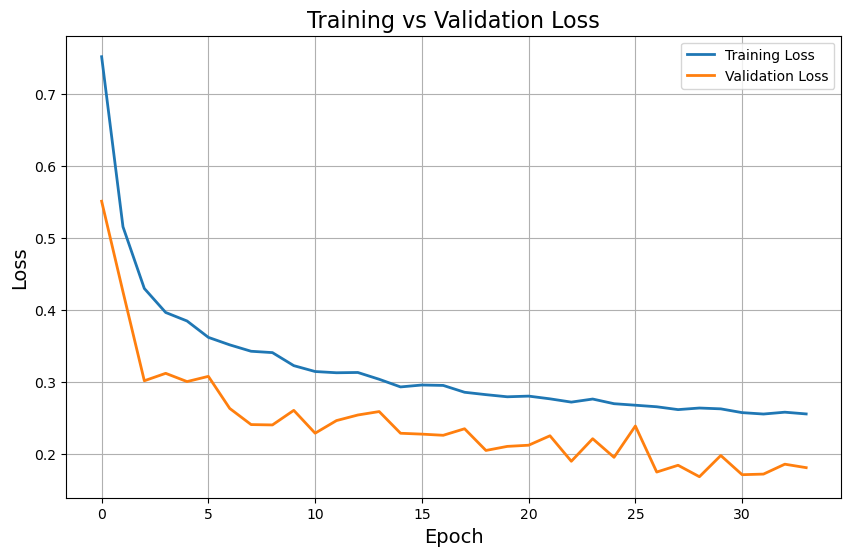

In [8]:
# ╔════════════════════════════════════════╗
# ║ 7. Plot training and validation curves ║
# ╚════════════════════════════════════════╝

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
